The aim of this report is to provide a comprehensive overview of the background, methodology, sources, thoughts and results of the project. Many information of the **Introduction** come from [[1](#ref-liang2025)].

_Even if this is formatted in markdown, references are included._

---

# 1. Introduction

Traditional machine learning models typically assume that training and test data are drawn from the same independent and identically distributed (i.i.d.) distribution. However, this assumption is often violated in real-world scenarios, where the test distribution may differ from the training distribution—a phenomenon known as _distribution shift_. This shift can significantly degrade the generalization performance of machine learning models \[[1](#ref-liang2025)].

To address this challenge, the research community has developed various techniques aimed at improving model robustness under distribution shifts. These methods can be broadly grouped into two main categories:

- **Domain Generalization (DG):** Learning models that generalize well to unseen domains during training.
- **Test-Time Adaptation (TTA):** Adapting a pre-trained model to the test domain during inference without retraining.

In this project, we focus on **Test-Time Adaptation (TTA)**, which has recently gained traction due to its ability to enhance model performance without requiring access to training data.

## A. Benefits of Test-Time Adaptation

1. **No reliance on training data:** TTA can function without access to the original training data, making it ideal for privacy-sensitive or resource-restricted environments.
2. **Adaptation to unseen domains:** TTA enables models to adapt dynamically to new domains at inference time.
3. **Leverages test data:** By using test data for adaptation, TTA can significantly improve performance on out-of-distribution samples.

   - Unlike DG, which often requires both labeled source and unlabeled target data during training, TTA can be deployed independently, making it more versatile in certain applications.

## B. Drawbacks of Test-Time Adaptation

1. **Risk of overfitting:** Small or unrepresentative test datasets may lead to overfitting during adaptation.
2. **Assumption of distribution similarity:** TTA generally assumes that test data is not too far from the training distribution, which may not always hold.
3. **Computational overhead:** The additional computation required for adaptation can be prohibitive in low-resource settings.

## C. Categories of TTA Methods

TTA approaches can be categorized based on the nature and scope of their adaptation strategy:

### 1. **Test-Time Domain Adaptation (TTDA)**

Also known as _source-free domain adaptation_, TTDA uses multiple unlabeled test batches and performs multi-epoch adaptation before making predictions.

### 2. **Test-Time Batch Adaptation (TTBA)**

TTBA adapts the model using individual test batches or instances, with no inter-batch dependency. Each batch is processed independently.

### 3. **Online Test-Time Adaptation (OTTA)**

OTTA adapts the model in an online fashion: test batches are seen only once, and adaptation occurs incrementally using knowledge from previous batches to inform future adaptation.

Let $b_1, \dots, b_m$ represent $m$ unlabeled mini-batches encountered during test time:

- **TTDA**: Uses all $m$ batches for multi-epoch adaptation before final predictions.
- **TTBA**: Adapts on a per-batch or per-instance basis; batches are treated independently.
  - **TTIA**: Also called Episodic Test-Time Adaptation (ETTA), is TTBA with a batch size of 1, where each instance is adapted independently.
- **OTTA**: Adapts sequentially, using prior knowledge from earlier mini-batches to improve performance on subsequent ones.

### Notes on Overlap

- OTTA can be applied in multi-epoch settings similar to TTDA.
- TTBA can be integrated into OTTA frameworks if knowledge from earlier instances is reused.

## D. Project Scope

In this project, we focus on **TTA for image classification**, particularly using **CLIP** [[2](#ref-clip2021)] with **TPT** [[3](#ref-tpt2022)]. Our approach involves adapting the model on **single-image test instances**, with the model being reset to its pre-trained state after each instance. This resembles **TTIA**, keeping the constraint of no retention of prior test-time knowledge (between batches, so between images).

![](img/tpt.png "Test-Time Prompt Tuning (TPT) for CLIP")

A comprehensive list of TTA methods is provided at [GitHub - TTIA, Clip Related](https://github.com/tim-learn/awesome-test-time-adaptation/blob/main/TTA-TTBA.md/#clip-related).

# 2. TTIA

> **Definition**: "_Test-Time Instance Adaption, TTIA_ Given a classifier $f_\mathcal{S}$ learned on the source domain $\mathcal{D_s}$, and an unlabeled target instance $x_t \in \mathcal{D_T}$ under distribution shift, _test-time instance adaption_ aims to leverage the labeled knowledge implied in $\mathcal{f_S}$ to infer the label of $x_t$ adaptively" [[1](#ref-liang2025)]. In other words, TTIA aims to adapt the classifier $f_\mathcal{S}$ to the target instance $x_t$ by leveraging the knowledge of the source domain $\mathcal{D_S}$.

TTIA differs from TTBA in that single-instance adaption is performed, instead of batch-wise adaption, giving an example the difference is between classifying a single frame of a video and classifying a sequence of frames. In both methods no memory of the previous test-time knowledge is retained.

## A. Common Techniques (and some not only for TTIA)

It follows a list of techniques that can be used for this project (TTIA for image classification). This list is not exhaustive, a bigger one can be found in the paper [[1](#ref-liang2025)] and linked above in the **Project Scope** section.
This list has the objective to provide a quick overview of the techniques that can be used for TTIA, and to give some ideas for possible improvements on TPT [[3](#ref-tpt2022)].

### Test-Time Augmentation

Generally, test-time augmentation techniques do not explicitly consider distribution shifts but can be advantageous for TTA methods.
Most known are:

- AugMix
- estimate uncertainty: Smith, L., & Gal, Y. (2018). Understanding measures of uncertainty for adversarial example detection. In Proceedings of UAI (pp. 560–569).
- enhance robustness: Pérez, J. C., Alfarra, M., Jeanneret, G., Rueda, L., Thabet, A., Ghanem, B., & Arbeláez, P. (2021). Enhancing adversarial robustness via test-time transformation ensembling. In Proceedings of ICCV (pp. 81–91).
- we could even try to get inspired by **MobileCLIP**'s reinforcement dataset method.

### Batch Normalization Calibration

Batch normalization (BN) is a widely used technique in deep learning that normalizes the activations of each layer in a mini-batch. This is done to improve the training speed and stability of the model. Obviously, methods that rectify BN suffer when the batch size is small and many are not directly applicable to TTIA, as they requir multiple test batches. However, some techniques have been proposed to adapt BN statistics during test time:

- SaN [[4](#ref-san2022)] attempts to mix instance normalizatoin (IN [[5](#ref-in2016)]) statistics estimated per instance with the training BN statistics.
- InstCal [[6](#ref-instcal2022)] introduces a module to learn the interpolating weight between (IN [[5](#ref-in2016)]) and BN statistics, allowing the network to adjust the importance of training statistics for each test instance. > TODO: check this, it looks like this paper has nothing to do with TTIA.
- SITA [[7](#ref-sita2021)] expands a single instance to a bathc of instance using random augmentation, then estimates the BN using the weighted average over these augmented instances.

### Model Optimization

Involces adjusting the parameters of a pre-trained model for each unlabled test instance. There are two main approaches:

1. **Training with auxiliary tasks**: introduce a self-supervised task in the primary during both training and test phases
   - **Not** directly **applicable** to TTIA and our project, as it requires not only TTA but also training.
1. **Fine-tuning**: designing task-specific opjective for updating the pre-trained model.

#### Training-Agnostic Fine-Tuning

Fine-tuning with unsupervised objectives.

- MEMO [[8](#ref-memo2021)]: optimizes the netropy of the averagd prediction over multiple random aumgentations of the input sample.
- PromptAlign [[9](#ref-promptalign2023)]: handle train-test distribution shift by aligning mean and variances fo the test sample and the source dataset statistics. TODO: check if it's compatible.
- SUTA [[10](#ref-suta2022)]: minimum class confusion to reduce uncertainty. This is for Automatic Speech Recognition, but maybe something can be used for image classification. TODO: check if it's compatible.
- RLCF [[11](#ref-rl2023)]: TTA with feedback to rectify the model output and prevent the model from becoming blindly confident - reinforcement learning with CLIP feedback.
- Deep Matching [[12](#ref-deepmatching)]: image matching with a pre-trained model. TODO: check compatibility.
- Image generation, which Ettore doesn't like so he didn't search any paper about it.

### Meta-Learning

Not directly applicable to our project (TODO: check if I'm wrong, 99% i'm right). Won't be analyzed further.

### Input Adaption

Focuses on changing input data for pre-trained models. Notable techniques include:

- TPT [[3](#ref-tpt2022)]: freezes the pre-trained multimodal model (CLIP) and only learns the extra text prompt based on the marginal entropy of each instance.
- CVP [[13](#ref-cvp2023)]: optimizes the convolutional visual prompts in the input under the guidance of a self-supervised contrastive learning objective. TODO: check compatibility.
- TTA-AE, TTA-DAE, TTO-AE, AdvTTT may be interesting, skipped.
- TAF-Cal [[14](#ref-tafcal2022)]: utilizes the average amplitude feature over the training data to perform Fourier style calibration at both training and test phases. TODO: check compatibility.
- data manifold constraint can aid in achieving better alignemnt between test data and unseen training data.
  - probably not compatible, it's in the survey.
- ESA [[15](#ref-esa2023)]: update the target feature by energy minimization through Langevin dynamics. TODO: check compatibility.
- AntiAdv [[16](#ref-antiadv)]: anti-adversary layer, aimed at countering this effect. In particular, our layer generates an input perturbation in the opposite direction of the adversarial one and feeds the classifier a perturbed version of the input. Our approach is training-free and theoretically supported

### Dynamic Inference

- LAME [[17](#ref-lame2022)]: neighbor conssitency to enforce consistent assignments on neighboring points in the feature space, without modifying the pre-trained mdoel.

### Other (not born for TTA/TTIA)

- **Label Propagation for Deep Semi-supervised Lear**ning: which seeks local smoothness by maximizing the pairwise similarities between nearby data points. For TTA tasks, these semi-supervised learning techniques can be easily integrated to unsupervisedly update the pre-trained model during adaptation.

---

# Bibliography

1. <a id="ref-liang2025"></a> Liang J., He R., Tan T. (2025). _A Comprehensive Survey on Test-Time Adaptation Under Distribution Shifts_. IJCV, 133, 31-64, [Link](https://doi.org/10.1007/s11263-024-02181-w)
1. <a id="ref-clip2021"></a> Radford A., Kim K. J., Hallacy C., et al. (2021). _Learning Transferable Visual Models From Natural Language Supervision_. ICML 2021, 8748-8763, [Link](https://arxiv.org/abs/2103.00020)
1. <a id="ref-tpt2022"></a> Shu M., Nie W., Huang D., et al. (2022). _Test-time Prompt Tuning for Zero-Shot Generalization in Vision-Language Models_. NeurIPS 2022, [Link](https://arxiv.org/abs/2209.07511)
1. <a id="ref-san2022"></a> Bahmani S., et al. (2022) _Semantic Self-adaptation: Enhancing Generalization with a Single Sample_. TMLR 2023, [Link](https://arxiv.org/abs/2208.05788v2)
1. <a id="ref-in2016"></a> Ulyanov D., et al. (2016). _Instance Normalization: The Missing Ingredient for Fast Stylization_. [Link](https://arxiv.org/abs/1607.08022)
1. <a id="ref-instcal2022"></a> Zou. Y., et al. (2022). _PseudoSeg: Designing Pseudo Labels for Semantic Segmentation_. ICLR 2021, [Link](https://arxiv.org/abs/2010.09713)
1. <a id="ref-sita2021"></a> Khurana A., et al. (2021). _SITA: Single Image Test-time Adaptation_. [Link](https://arxiv.org/abs/2112.02355)
1. <a id="ref-memo2021"></a> Zhang M., et al., (2021). _MEMO: Test Time Robustness via Adaptation and Augmentation_, NeurIPS 2022, [Link](https://arxiv.org/abs/2110.09506)
1. <a id="ref-promptalign2023"></a> Hassan J., et al. (2023). _Align Your Prompts: Test-Time Prompting with Distribution Alignment for Zero-Shot Generalization_. NeurIPS 2023, [Link](https://arxiv.org/abs/2311.01459)
1. <a id="ref-suta2022"></a> Liu, G. at al. (2022). _Listen, Adapt, Better WER: Source-free Single-utterance Test-time Adaptation for Automatic Speech Recognition_. Interspeech 2022, [Link](https://arxiv.org/abs/2203.14222)
1. <a id="ref-rl2023"></a> Zhao S., at al. (2023). _Test-Time Adaptation with CLIP Reward for Zero-Shot Generalization in Vision-Language Models_. ICLR 2024, [Link](https://arxiv.org/abs/2305.18010)
1. <a id="ref-deepmatching"></a> Hong S., Kim S. (2021) _Deep Matching Prior: Test-Time Optimization for Dense Correspondence_. IEEE/CVF 2021, [Link](https://arxiv.org/abs/2106.03090)
1. <a id="ref-cvp2023"></a> tsai Y., et al. (2023). _Convolutional Visual Prompt for Robust Visual Perception_, [Link](https://arxiv.org/abs/2303.00198)
1. <a id="ref-tafcal2022"></a> Zhao X., et al. (2022). _Test-time Fourier Style Calibration for Domain Generalization_. IJCAI 2022, [Link](https://arxiv.org/abs/2205.06427)
1. <a id="ref-esa2023"></a> Xiao Z., et al. (2023). _Energy-Based Test Sample Adaptation for Domain Generalization_. ICLR 2023, [Link](https://arxiv.org/abs/2302.11215)
1. <a id="ref-antiadv"></a> Alfarra M., at al. (2021). _Combating Adversaries with Anti-Adversaries_. AAAI 2022, [Link](https://arxiv.org/abs/2103.14347)
1. <a id="ref-lame2022"></a> Boudiaf M., et al. (2022). _Parameter-free Online Test-time Adaptation_. CVPR 2022. [Link](https://arxiv.org/abs/2201.05718)
1. <a id="ref-augmix"></a> Hendrycks D., et al. (2019). _AugMix: A Simple Method to Improve Robustness and Uncertainty for Deep Learning_. ICLR 2020, [Link](https://arxiv.org/abs/1912.02781)\
1. <a id="ref-kornia"></a> Kornia: _Differentiable Computer Vision Library for PyTorch_. [Link](https://arxiv.org/abs/1910.02190)


---

# 3. Reproducing TPT

For this project `ViT-B/32` is used as the CLIP model.

## A. Need for Efficiency: Faster AugMix

TPT and other TTA techniques, as already seen, use image augmentation to improve the performance of the model. Usually torchvision's AugMix [[18](#ref-augmix)] is used, but it's quite slow. For this reason it has been rewritten using kornia [[19](#ref-kornia)] which is more efficient and can be more easily customized and extended. It follows it's implementation and a small performance test to compare it with the original one.

The usage of Kornia for AugMix is a way to speed up the process, as it's differentiable its gradients are suppressed. Performance wise performing random augmentation on images is not "well parallelizable" on a GPU, still some performance improvements can be achieved and the data can be kept on the GPU, avoiding _useless_ data transfers. Better performances when performing e.g. random cropping, resizing are expected.

1. Note that the performances of Kornia are generally better than torchvision's, as can be seen in [Kornia's Benchmark](https://kornia.readthedocs.io/en/stable/augmentation.html#benchmark).
1. It has been noted that there are training [performance (model wise, accuracy) issues](https://discuss.pytorch.org/t/significant-difference-in-performance-between-torchvision-and-kornia-image-augmentations/97596) when comparing Kornia and torchvision, this is not covered in this project.


In [1]:
# Utils

from matplotlib import pyplot as plt
import torchvision.transforms.functional as TF


def plot_images(images):
    cols = 8
    rows = (images.shape[0] + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(images.shape[0]):
        plt.subplot(rows, cols, i + 1)

        img = images[i].permute(1, 2, 0).cpu().numpy()
        if img.dtype.kind == "f":  # float
            img = img.clip(0, 1)  # ensure in [0, 1]

        plt.imshow(img)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [2]:
import torch
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
torch.cuda.manual_seed(42)

import torchvision
import time
from tqdm import tqdm

image = torchvision.io.read_image(
    "datasets/imagenet-a/n01641577/0.038738_agama _ newt_0.7465035.jpg"
)

n_times = 100
n_augmentations = 63

In [3]:
# Original AugMix (torchvision_
# The `preprocess` comes from `clip.load("ViT-B/32")`
# The idea is to augment the same image `n` times (as if they were different batches) and get the average latency.
# The code follows a straightforward approach to augment the image as done for TPT: [B, C, H, W], where B is
# composed by `n` augmentation images and 1 original image.
# Output for both methods is a tensor of shape [B, C, H, W] where B = n + 1.

# Note that Kornia's AugMix is similar to the original AugMix, it's not exactly the same. The main difference
# is that it runs on the GPU, thus using it to perform similar operations is way faster (not tested here).

preprocess = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(
            size=224,
            interpolation=torchvision.transforms.InterpolationMode.BICUBIC,
            max_size=None,
            antialias=True,
        ),
        torchvision.transforms.CenterCrop(size=(224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

augmix = torchvision.transforms.AugMix()

transform = torchvision.transforms.Compose([augmix, preprocess])

# Compose needs PIL images, so we need to convert it
# Image casting is not benched as it could easily be done in the dataloader
# by reading the image with PIL instead of torch.
pil_image = torchvision.transforms.functional.to_pil_image(image)

start = time.time()
for i in tqdm(range(n_times)):
    transformed = [transform(pil_image) for _ in range(n_augmentations)]
    transformed = torch.stack(transformed)
end = time.time()

torchvision_latency = (end - start) / n_times * 1000
print(f"torchvision latency: {torchvision_latency:.2f} ms")

plot_images(transformed)

 25%|██▌       | 25/100 [00:28<01:26,  1.15s/it]


KeyboardInterrupt: 

In [3]:
from typing import Optional, List

import numpy as np
import kornia
import kornia.augmentation as K
import kornia.enhance as Ke


class AugMixKornia(nn.Module):
    def __init__(
        self,
        severity: int = 3,
        width: int = 3,
        depth: int = -1,
        alpha: float = 1.0,
        mixture_width: int = 3,
        chain_depth: int = 3,
        all_ops: bool = True,
        device: Optional[str] = None,
    ):
        """
        AugMix implementation using Kornia with closer fidelity to the original paper.

        Args:
            severity: Severity level of augmentations (1-10)
            width: Width of augmentation chain (not used directly, kept for compatibility)
            depth: Depth of augmentation chain (-1 for random between 1-3)
            alpha: Dirichlet distribution parameter for mixing weights
            mixture_width: Number of augmentation chains to mix
            chain_depth: Number of operations in each chain
            all_ops: Whether to use all augmentation operations
            device: Device to run on (cuda/cpu)
        """
        super().__init__()

        self.severity = severity
        self.alpha = alpha
        self.mixture_width = mixture_width
        self.chain_depth = chain_depth if depth <= 0 else depth
        self.all_ops = all_ops
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        # Define augmentation operations
        self.augmentations = self._get_augmentations()

    def _get_augmentations(self) -> List[nn.Module]:
        """Create a list of augmentation operations that will be randomly applied"""
        severity_factor = self.severity / 10.0

        if self.all_ops:
            # Full set of augmentations similar to original AugMix
            return [
                # AutoContrast
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                # Equalize
                Ke.equalize,
                # Posterize
                K.RandomPosterize(bits=max(1, 8 - self.severity), p=1.0),
                # Rotate
                K.RandomRotation(
                    degrees=(-30 * severity_factor, 30 * severity_factor), p=1.0
                ),
                # Solarize
                K.RandomSolarize(
                    thresholds=0.5, additions=(0.0, 0.1 * self.severity), p=1.0
                ),
                # Shear
                K.RandomAffine(
                    degrees=0,
                    shear=(-15 * severity_factor, 15 * severity_factor),
                    p=1.0,
                ),
                # Translate
                K.RandomAffine(
                    degrees=0,
                    translate=(0.1 * severity_factor, 0.1 * severity_factor),
                    p=1.0,
                ),
                # ColorJitter
                K.ColorJitter(
                    brightness=0.1 * self.severity,
                    contrast=0.1 * self.severity,
                    saturation=0.1 * self.severity,
                    hue=0.1,
                    p=1.0,
                ),
            ]
        else:
            # Simplified version
            return [
                K.ColorJitter(
                    brightness=0.1 * self.severity, contrast=0.1 * self.severity, p=1.0
                ),
                Ke.equalize,
                K.RandomAffine(
                    degrees=(-15 * severity_factor, 15 * severity_factor), p=1.0
                ),
            ]

    def _apply_augmentation_chain(self, image: torch.Tensor) -> torch.Tensor:
        """
        Apply a random sequence of augmentations to an image.

        Args:
            image: Input image tensor (C, H, W)

        Returns:
            Augmented image tensor (C, H, W)
        """
        # Randomly select augmentations for this chain
        op_indices = np.random.choice(
            len(self.augmentations), size=self.chain_depth, replace=True
        )

        augmented = image  # Don't clone immediately
        for op_idx in op_indices:
            augmented = self.augmentations[op_idx](augmented)

        return augmented.squeeze(0)

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        """
        Apply AugMix to a batch of images.

        Args:
            images: Input batch of images (B, C, H, W) or (C, H, W)

        Returns:
            Augmented batch (same shape as input)
        """
        # Input validation
        if not isinstance(images, torch.Tensor):
            images = K.image_to_tensor(images)

        if images.dim() == 3:
            images = images.unsqueeze(0)

        # Move to device if needed
        if images.device != self.device:
            images = images.to(self.device)

        batch_size = images.shape[0]

        # Sample mixing weights from Dirichlet distribution
        weights = (
            torch.from_numpy(
                np.random.dirichlet([self.alpha] * self.mixture_width, size=batch_size)
            )
            .float()
            .to(self.device)
        )  # Shape (B, mixture_width)

        # Sample weights for mixing with original
        mix_weights = (
            torch.from_numpy(
                np.random.dirichlet([self.alpha, self.alpha], size=batch_size)
            )
            .float()
            .to(self.device)
        )  # Shape (B, 2)

        # Generate augmented versions for each mixture component
        # Pre-allocate memory for augmented versions
        augmented = torch.empty(
            (self.mixture_width, batch_size, *images.shape[1:]), device=self.device
        )

        for i in range(self.mixture_width):
            augmented[i] = self._apply_augmentation_chain(images)

        # Weighted sum of augmented versions
        mixed = torch.einsum("mbchw,bm->bchw", augmented, weights).to(self.device)

        # Final mix with original image
        result = (
            mix_weights[:, 0:1, None, None] * images
            + mix_weights[:, 1:2, None, None] * mixed
        )

        return result.squeeze(0) if result.shape[0] == 1 else result

In [4]:
import kornia.constants


kornia_preprocess = nn.Sequential(
    K.SmallestMaxSize(
        224,
        resample=kornia.constants.Resample.BICUBIC,
    ),
    K.CenterCrop(
        size=(224, 224),
        resample=kornia.constants.Resample.BICUBIC,
    ),
    kornia.enhance.Normalize(
        mean=torch.tensor([0.48145466, 0.4578275, 0.40821073]),
        std=torch.tensor([0.26862954, 0.26130258, 0.27577711]),
    ),
)

kornia_augmix = AugMixKornia()

100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Latency per image: 476.5285 ms


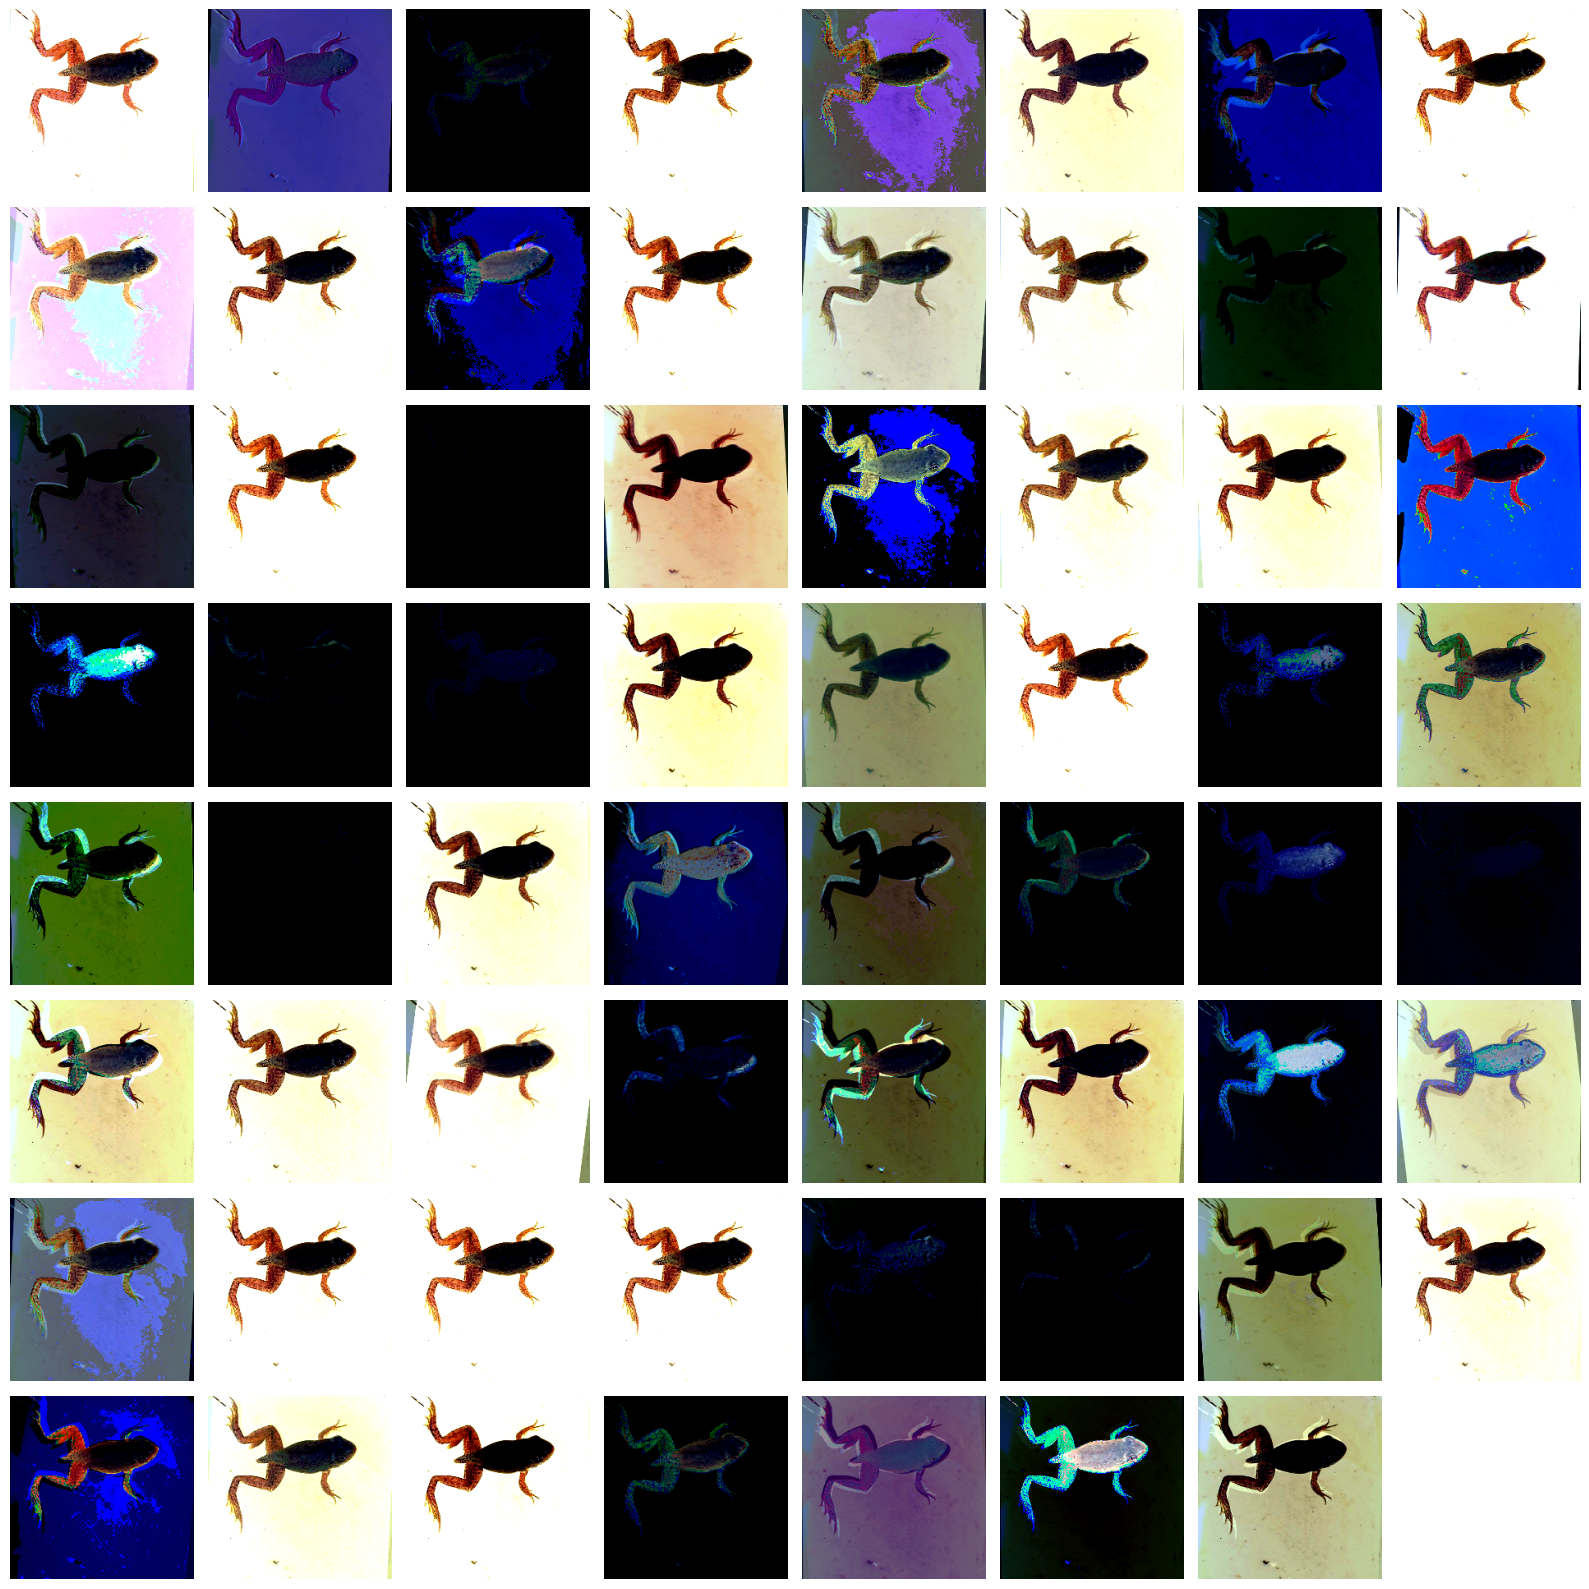

In [ ]:
start = time.time()
for i in tqdm(range(n_times)):
    images = image.float().div(255).repeat(63, 1, 1, 1)
    views = kornia_augmix(images)
    views = kornia_preprocess(views)
end = time.time()

kornia_latency = (end - start) / n_times * 1000
print(f"Latency per image: {kornia_latency:.4f} ms")

plot_images(views.to("cpu"))

In [ ]:
from IPython.display import Markdown

Markdown(
    f"""
**Table 1**: Performance comparison between torchvision and kornia implementations of AugMix. Test performed on a single NVIDIA RTX 4060 (140W, performance mode).

<div align="center">

| Implementation | Times (_ms_) |
| :------------: | :----------: |
|  torchvision   |   ${torchvision_latency:.2f}$    |
|     kornia     |   ${kornia_latency:.2f}$    |
|    $\Delta$    |   ${torchvision_latency-kornia_latency:.2f}$    |

</div>

It's worth noting that the performance of the Kornia implementation is not as good as expected, but it is still better than the original one. The difference in performance is due to the fact that the Kornia implementation is not fully optimized and can be further improved.
"""
)


**Table 1**: Performance comparison between torchvision and kornia implementations of AugMix. Test performed on a single NVIDIA RTX 4060 (140W, performance mode).

<div align="center">

| Implementation | Times (_ms_) |
| :------------: | :----------: |
|  torchvision   |   $742.37$    |
|     kornia     |   $552.19$    |
|    $\Delta$    |   $190.18$    |

</div>

It's worth noting that the performance of the Kornia implementation is not as good as expected, but it is still better than the original one. The difference in performance is due to the fact that the Kornia implementation is not fully optimized and can be further improved.


### a.) Preprocess

The preprocessing done with Kornia needs to be the same as the one done with torchvision (`torchvision.transforms.Compose` saw above). This is verified by comparing the output of the two implementations.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


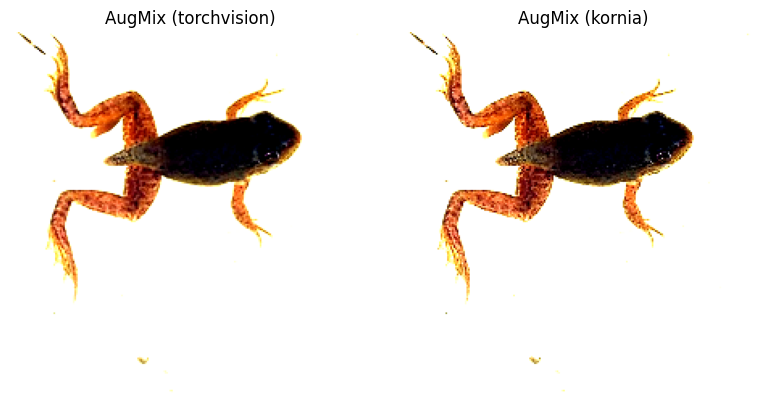

In [ ]:
import matplotlib.pyplot as plt


pil_image = torchvision.transforms.functional.to_pil_image(image)

preprocessed_torchvision = preprocess(pil_image)

### ---
preprocessed_kornia = kornia_preprocess(image.float().div(255)).squeeze(0)

# Visuaize both on the same plot and row
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # 1 row, 2 columns

axes[0].imshow(preprocessed_torchvision.permute(1, 2, 0).cpu().numpy())
axes[0].set_title("AugMix (torchvision)")
axes[0].axis("off")

axes[1].imshow(preprocessed_kornia.permute(1, 2, 0).cpu().numpy())
axes[1].set_title("AugMix (kornia)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# # Check if the outputs are the same
# assert torch.allclose(
#     preprocessed_torchvision, preprocessed_kornia
# ), "Outputs are not the same!"

In [6]:
# Cleaning
del image
del n_times
del n_augmentations
del preprocess
del augmix
del transform
del pil_image
del start
del end
del torchvision_latency
del kornia_latency
del preprocessed_torchvision
del preprocessed_kornia

with torch.no_grad():
    torch.cuda.empty_cache()

NameError: name 'end' is not defined

## B. Dataset, Dataloader and Augmentation

The dataset is straightforward, it directly loads images in the GPU (not reccomended, but as this is thought as TTA, in a real scenario you can't pre-fetch images, so multiple threads for data loading are not used).
The dataloader must be set to `num_workers=0` to avoid problems with CUDA.
A custom `collate_fn` is used to avoid adding a "useless" dimension to the tensor, as we work with single images, not batches. Even tho the dataloader returns multiple images in a batch, which are the original image + augmented images.


In [5]:
from torch.utils.data import Dataset
import os


class ImageNetADataset(Dataset):
    """
    Custom Dataset class for the ImageNet-A dataset.

    Set the `transform` parameter so that images work with your model.
    Example usage:
    ```python
        model, transform = clip.load("ViT-B/32")
        dataset = ImageNetADataset(<path>, transform=transform)
    ```
    ----

    The dataset is organized into subdirectories, each named with a class code (e.g., "n01614925").
    Each subdirectory contains images belonging to that class. The dataset also includes a README.txt file that maps class codes to human-readable names.

    The dataset is expected to be structured as follows:
    ```
    datasets/imagenet-a/
        n01440764/
            image1.jpg
            image2.jpg
            ...
        n01614925/
            image1.jpg
            image2.jpg
            ...
        ...
        README.txt
    ```

    """

    def __init__(self, root_dir="datasets/imagenet-a", transform=None):
        """
        Args:
            root_dir (str): Root directory of the ImageNet-A dataset.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform

        self.__download_if_needed()

        # Load mapping from class codes (e.g., "n01614925") to human-readable names
        readme_path = os.path.join(root_dir, "README.txt")
        self.class_code_to_label = self._load_class_mapping(readme_path)

        # Filter valid class directories that match the mapping
        self.class_codes = sorted(
            [
                d
                for d in os.listdir(root_dir)
                if os.path.isdir(os.path.join(root_dir, d))
                and d in self.class_code_to_label
            ]
        )

        # Map class codes to indices
        self.class_code_to_idx = {
            code: idx for idx, code in enumerate(self.class_codes)
        }

        # Collect all image file paths and corresponding labels
        self.samples = self._gather_samples()

        # Inverse mapping from label index to class name
        self.idx_to_label = {
            idx: self.class_code_to_label[code]
            for code, idx in self.class_code_to_idx.items()
        }

    def __download_if_needed(self):
        """
        Check if the dataset is already downloaded. If not, download it.
        """
        if not os.path.exists(self.root_dir):
            raise FileNotFoundError(
                f"Dataset not found at {self.root_dir}. Please download it first."
            )

    def _load_class_mapping(self, readme_path):
        """
        Load class code to human-readable name mapping from README.txt.
        Skips header lines and parses lines in format: 'n01440764 tench'.
        """
        mapping = {}
        with open(readme_path, "r") as file:
            lines = file.readlines()[12:]  # Skip first 12 header lines
            for line in lines:
                parts = line.strip().split(" ", 1)
                if len(parts) == 2:
                    code, name = parts
                    mapping[code] = name
        return mapping

    def _gather_samples(self):
        """
        Walk through each class directory to gather image paths and corresponding labels.
        """
        samples = []
        for class_code in self.class_codes:
            class_dir = os.path.join(self.root_dir, class_code)
            for filename in os.listdir(class_dir):
                if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                    image_path = os.path.join(class_dir, filename)
                    label = self.class_code_to_idx[class_code]
                    samples.append((image_path, label))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Load image and return dictionary containing image, label index, and class name.

        Returns:
            image (tensor)
            label (tensor)
        """
        image_path, label = self.samples[idx]

        image = torchvision.io.read_image(image_path).float() / 255.0

        if image.shape[0] == 1:  # Grayscale → RGB
            image = image.repeat(3, 1, 1)

        elif image.shape[0] == 4:  # RGBA → RGB
            image = image[:3, :, :]

        elif image.shape[0] != 3:
            raise ValueError(f"Unsupported number of channels: {image.shape[0]}")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

    def get_class_name(self, idx):
        """
        Get human-readable class name for a given index.
        """
        return self.idx_to_label[idx]

In [6]:
class ImageTransform(nn.Module):
    def __init__(self, model_transform, custom_transform=None, n_views=63, device=None):
        super().__init__()
        self.model_transform = model_transform
        self.custom_transform = custom_transform
        self.n_views = n_views
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")

        self.eval()
        # self.model_transform.eval()
        # self.custom_transform.eval() if custom_transform is not None else None

    def __call__(self, image: torch.Tensor) -> torch.Tensor:
        """
        Apply the model transform and custom transform to the image.
        """
        with torch.no_grad():
            image = image.to(self.device)

            if self.custom_transform is not None:
                views = image.repeat(self.n_views, 1, 1, 1)
                views = self.custom_transform(views)
                views = torch.cat([views, image.unsqueeze(0)], dim=0)
                views = self.model_transform(views)

                return views
            else:
                return self.model_transform(image)

In [7]:
from torch.utils.data import DataLoader


def ResnetA(
    augmenter: ImageTransform,
    root_dir="datasets/imagenet-a",
):
    """
    Create a DataLoader for the ImageNet-A dataset. Defaults to 1 element per batch.
    Non modifiable. No shuffling.
    Args:
        augmenter (callable):
        root_dir (str): Root directory of the ImageNet-A dataset.

    Returns:
        dataloader (DataLoader): DataLoader for the ImageNet-A dataset.
        dataset (ImageNetADataset): The underlying dataset object.
    """

    def collate_fn(batch):
        """
        Custom collate function to handle the batch of images and labels.
        """

        images = batch[0][0]

        if images.ndim == 3:
            images = images.unsqueeze(0)

        labels = batch[0][1]

        return images, labels

    dataset = ImageNetADataset(root_dir=root_dir, transform=augmenter)
    dataloader = DataLoader(
        dataset,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        collate_fn=collate_fn,
    )

    return dataloader, dataset

## C. Baseline Pure - ViT-B/32 (no TPT)

ViT-B/32 model from HuggingFace without any TTA or augmentation. Model is used for one-shot inference only, no training or fine-tuning is done.


In [ ]:
import clip
import torch.nn.functional as F

## Dataloader
augmenter = ImageTransform(model_transform=kornia_preprocess, n_views=0)
augmenter.eval()

dataloader, dataset = ResnetA(augmenter)

## Model
model, _ = clip.load("ViT-B/32", device=device)
model.eval()

# remove the requires grad
for param in model.parameters():
    param.requires_grad = False

# Prepare prompts
prompt = torch.cat(
    [clip.tokenize(f"a photo of a {c}") for c in dataset.class_code_to_label.values()]
).to(device)

# with torch.no_grad():


# Init confusion matrix
num_classes = len(dataset.class_code_to_label)
conf_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int32)

#
total = 0
correct = 0

# Evaluation
start = time.time()


for image, label in tqdm(dataloader):
    image = image.to(device)
    label = label.to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        text_features = model.encode_text(prompt)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        logits = (image_features @ text_features.T).softmax(dim=-1)
        # pred_class = logits.argmax(dim=-1)

        marginal_prob = F.softmax(logits, dim=1).mean(0)
        pred_class = marginal_prob.argmax().item()

        total += 1
        correct += int(pred_class == label.item())

        # labels = label.view(-1)
        # for true, pred in zip(labels, pred_class):
        #     conf_matrix[true.item(), pred.item()] += 1
        if total == 256:
            break

end = time.time()

# Accuracy
# total = conf_matrix.sum().item()
# correct = conf_matrix.diag().sum().item()
pure_accuracy = correct / total
pure_latency = (end - start) / total

print(f"Accuracy: {pure_accuracy * 100:.2f}%")
print(f"Latency: {pure_latency * 1000:.2f} ms")

  3%|▎         | 255/7500 [00:31<14:57,  8.07it/s]

Accuracy: 60.16%
Latency: 123.44 ms


In [56]:
del augmenter
del dataloader
del dataset
del model
del prompt
del text_features
del num_classes
del conf_matrix
del total
del correct

with torch.no_grad():
    torch.cuda.empty_cache()

# D. Baseline - ViT-B/32 - TPT

The TPT implementation is based on the one from the paper [[3](#ref-tpt2022)].

I'm working on it.


In [ ]:
augmenter = ImageTransform(
    model_transform=kornia_preprocess,
    custom_transform=kornia_augmix,
    n_views=63,
)

dataloader, dataset = ResnetA(augmenter)

for image, label in tqdm(dataloader):
    pass

  0%|          | 8/7500 [00:04<1:04:28,  1.94it/s]


KeyboardInterrupt: 